# TL;DR

We applied a probilistic machine learing approach to a dataset of hitchhiking waiting times around the world.
In comparison to previous endeavors we are able to make waiting time predictions for any spot on the globe that results in a complete world map that is also more accurate than previous partial maps despite our hard metrics and experienced hitchhikers. In addition we are able to model uncertainties of waiting time predictions to not pretend that our predictions are accurate where there is no evidence and to call hitchhikers to share their experience especially in the regions where we lack data till this day.

To achieve this we appliey a Gaussian process on data points in a 2D feature space (longitude, latitude) and quite noisy target values (waiting times). Specifically we made use of a kernel that involves three radial basis function kernels that each model a different scale on which waiting times in hitchhiking depend on each other. Besides that we built the model so that its predictions are inherently constrained to positive waiting times. Eventually we demonstrated how domain expertise can be used to tune the models hyperparameters.

You can find the original notebook and helper code here.

In [1]:
from utils import *
from map_utils import *
from models import *
from transformed_target_regressor_with_uncertainty import *
from numeric_transformers import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import TransformedTargetRegressor

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Throughout this notebook we are using a metric coordinate system.

We assume that hitchhiking success in a certain spot depends mostly on the density of the traffic and the attitude of the drivers. In this work we focus a little more on the latter assuming that cultural differences mostly deremine how quickly on is picked up on the road.

What do we want to achieve?
A worldmap of estimated hitchhiking waiting times. For this purpose, we have to develop a predictive model that estimates the waiting time for hitchhiking at any given location given the waiting times that were recorded on https://hitchmap.com/ since 2005 (most extensively from 2010 to 2016). For the following we are using the hitchwiki dump from 04/11/2024.
The map should be visually appealing. By that we mean that changes in the waiting time should not be to drastic and it should look organic in the way that it there are no hard straight edges visible.
To model/ map is evaluated subjectively by the hitchwiki community to make sure it is aligned with their vast experience in hitchhiking. Beyond that we are quantifying the quality of the map by the average deviation of the predicted waiting time from the actual waiting time. As the the problem at hand is a regression problem, this evaluation metric is referred to as mean absolute error (MAE). The rational behind this choice is that the MAE is easy to interpret and that we are dealing with extremely noisy data (ther is measurement noise for each data point especially for longer waiting times and there are outliers in the data caused by (bad) luck on the road) thus we want to avoid being punished to much by outliers an a root mean squared error (RMSE) would do. Still we are reporting the RMSE as well to give a more complete picture of the model performance.
Finally we want to build a model in which we can build in knowledge about hitchhiking in general but not about the the underlying world map. This importantly involves not building a sub-model for each region in a set of predefined regions as this process would be too manual, teadious and subjective.

# Getting started with simple models

To get a feeling for the models we are viewing a 1D-example first. To achieve this we are only using data points with roughly the same longitude value.
Specifically we are cutting horizontally through Germany at 51° latitude (roughly from Aachen to Görlitz), collecting all points that lie within a 10km strip around this cut and project them to 51° latitude.

Here we want to introduce the models that we will compare across all following experiments.
As a minimal benchmark we use model that always predicts the average waiting time - calling it AVERAGE.
Getting just a little more complex we are deviding the world into same-sized tiles and predict the average of all points in one tile for all locations that lie in that tile - calling it TILES.
As proposed by the single existing hitchhiking heatmap that is around since 2019 https://abelblogja.wordpress.com/average-waiting-times-in-europe/ we assume that each recorded waiting time gives us some certainty tha, polygon, mapt it is the correct approximated waiting time in the region around it. The decrease in certainty or the area a single point influences is modelled by a 2D normal distrget_distributionibution (Gaussian) with the mean at the point and a standard deviation of e.g. 50 km. To make a prediction at a new point the waiting times from all known points are weighted by the value of their Gaussian at the new point - calling it WEIGHTED AVERAGED GAUSSIANS.
Eventually we apply a Gaussian process (GP) model that we will focus on train in the following.

In the following we will compare the GP to the other models to develop a first understanding and make first changes to the model.



Shortcomings of other models:
hard edges
no uncertainty
no adaptive to amount of data per region

Kernel explaination 
latex

In [2]:
points, val = get_cut_through_germany()

In [3]:
wag_model = WeightedAveragedGaussian(region='germany')
wag_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(wag_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 24.050772731007733
 Training MAE 14.492408587081854
Validation RMSE: 29.202554515406614
 Validation MAE 19.08422522014841


In [4]:
average_model = Average()
average_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(average_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 28.883930945852764
 Training MAE 18.240333135038668
Validation RMSE: 26.11086058835615
 Validation MAE 16.88917924893535


In [5]:
tiles_model = Tiles(region='germany')
tiles_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(tiles_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 26.542649855998334
 Training MAE 15.744948589191775
Validation RMSE: 28.242465745522914
 Validation MAE 16.93535247432306


In [6]:
X = points[['lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)

# log1p as waiting time can be 0 which is not defined for log

log_transformer = LogTransformer()

In [7]:
sigma = 1.0

# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale_bounds=(1e4, 3e5))
kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rbf + WhiteKernel(noise_level_bounds=(4e-1, 1e0))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=True,
    n_restarts_optimizer=0,
    random_state=42,
)

target_transform_gpr = TransformedTargetRegressorWithUncertainty(regressor=gpr, transformer=log_transformer)

target_transform_gpr.fit(X, y)
target_transform_gpr.regressor_.kernel_

1**2 * RBF(length_scale=1.68e+05) + WhiteKernel(noise_level=0.741)

In [8]:
evaluate(target_transform_gpr, train=points, validation=val, features=['lon'])

Training RMSE: 26.634482147945906
 Training MAE 13.327888206317583
Validation RMSE: 28.36806803670023
 Validation MAE 17.519198483724313


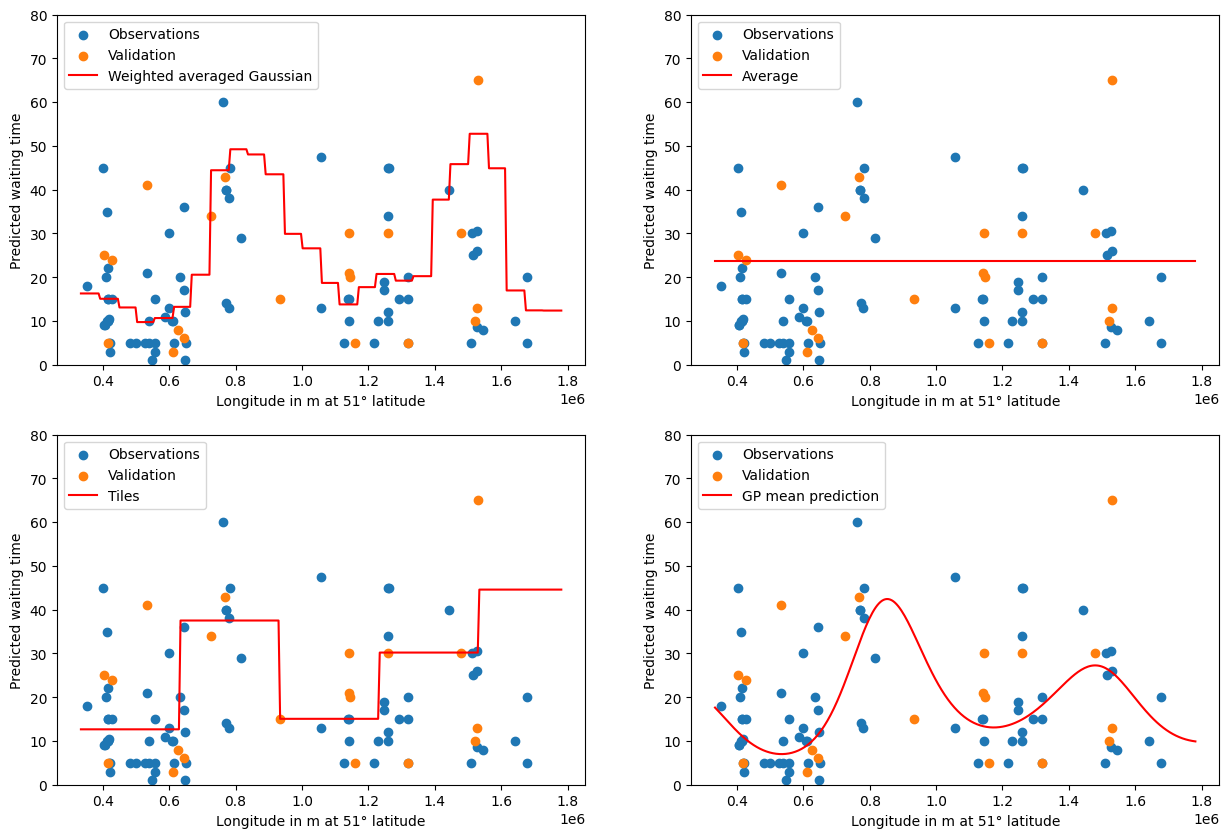

In [9]:
plot_1d_model_comparison(points, val, X, y, wag_model, average_model, tiles_model, target_transform_gpr)

# TODO: getting the real stdv in the original space see:
# https://stats.stackexchange.com/questions/401941/mean-and-error-bounds-of-log-transformed-data-using-gaussian-process-regression

In [10]:
stop

NameError: name 'stop' is not defined

With a first intuition for each of the models we want to take a look at some of the model choices in the Gaussian process.
The first thing to note is the transformation of the target values (waiting times). For GPs we can and have to specify our assumptions about the kinds of fuctions that can be leared from the data. These are called the prior. In general the prior assumes a 0-mean for the data and that the data points are normally distributed around this mean. It is obvious that waiting times have to be above 0 and are thus constraint which implies that the original data cannot be normally distributed.
To address this in our model we are subracting the average waiting time from each target value and applying a log-transformation to the waiting times which removes the constraint on the waiting times as it maps positive real numbers to all real numbers. The log-transformation most importantly prevents the function that will be predicted by our GP model to drop below 0 which might otherwise occur especially when assuming that the waiting times can deviate a lot from the mean and there is lot of noise in the data.
We can take a look how the target values look like after being transformed.
Keep in mind the when feeding transformed targets into our GP modelhttps://distill.pub/2020/bayesian-optimization/ we will have to invert the transformation when making preditions.

Text(0, 0.5, 'Waiting time')

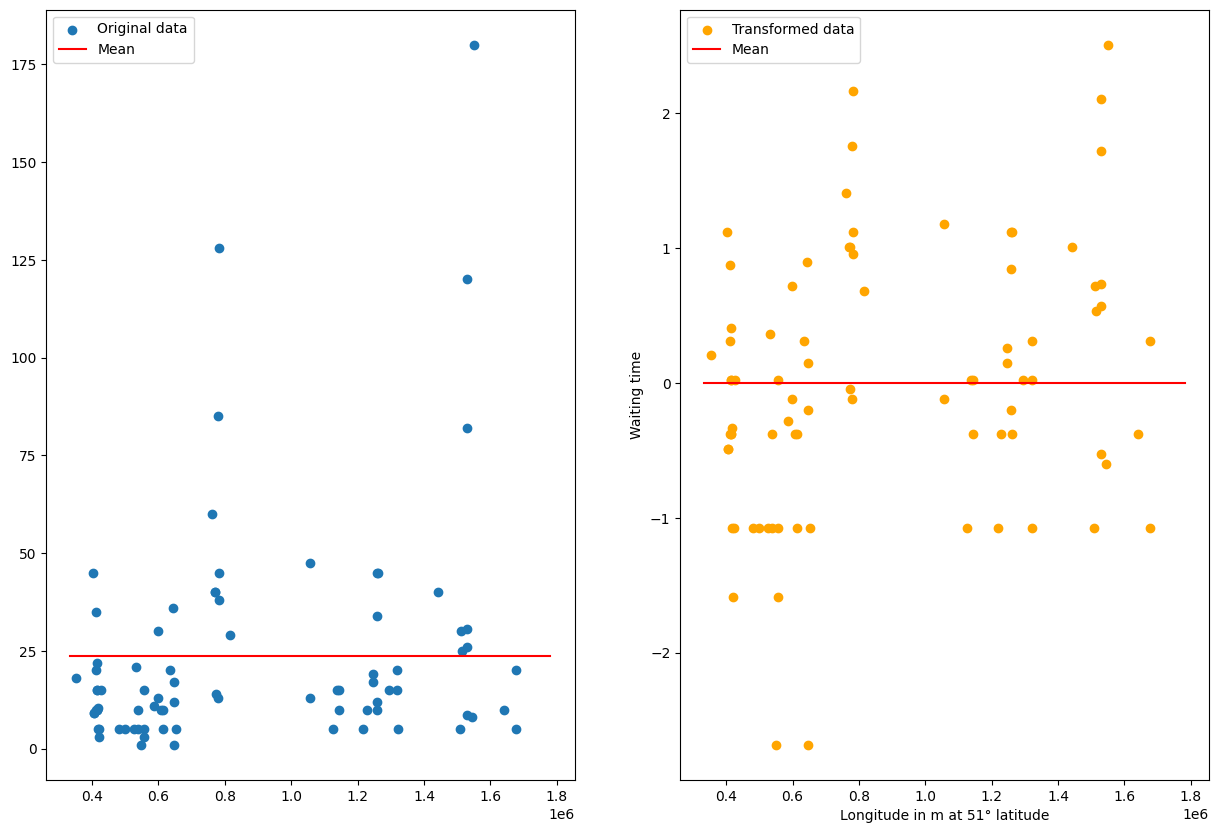

In [ ]:
X = points[['lon']].values
y_orig = points['wait'].values

log_transformer = TargetTransformer(function=np.log1p, inverse_function=np.expm1)
y = log_transformer.fit_transform(y_orig)

fig, ((ax1),(ax2)) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(X, y_orig, label="Original data")
ax1.plot(x_test, np.ones(x_test.shape[0]) * np.mean(y_orig), label="Mean", color='red')
ax1.legend()
ax2.scatter(X, y, label="Transformed data", color='orange')
ax2.plot(x_test, np.ones(x_test.shape[0]) * np.mean(y), label="Mean", color='red')
ax2.legend()


plt.xlabel("Longitude in m at 51° latitude")
plt.ylabel("Waiting time")


The form of the function a GP can predict is most importantly determined by its kernel (or covariance) function which determines how strong waiting times are correlated depending on their relative location and thus how known waiting times influence predictions in a new spot. A common choice for a kernel is the radial basis function kernel (RBF) in general results in smooth predicted functions.
The specific form of a RBF is deterimed by a variance (determining how much the function can deviate from the mean) and a lengthscale (determining how far each point can influence the form of the function) parameter. Besides that the covariance function allows to model the noise in each data point (how accurate they are). Assuming the same noise for each record of waiting time for now we get another parameter to tune. It is a good first choice for the variance parameter to set it to the variance of the training data. With this two hyperparameters remain that we want to set so that it results in a model that best reflects the underlying data.
Although we are evaluating on mean absolute error, what we consider a good model is determined by the log marginal likelihood that is the probability of observing the data at hand given a certain choice of parameters. So this becomes the loss function we are optimizing. In comparion to direcly optimizing the MAE it is less prone to overfitting to the data.
We will first view how the parameters to tweak influence the log marginal likelihood and from that on reason about a good choice of parameter values applying what we know about our environment and hitchhiking.
We consider a lengthscale between 100m and 10'000km and a noise of _ to _ in the transformed target value space.

In [ ]:
rbf = RBF(length_scale_bounds=(1e-100, 1e100))
kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rbf + WhiteKernel(noise_level_bounds=(1e-100, 1e100))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y)

GaussianProcessRegressor(alpha=0.0,
                         kernel=0.976**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=42)

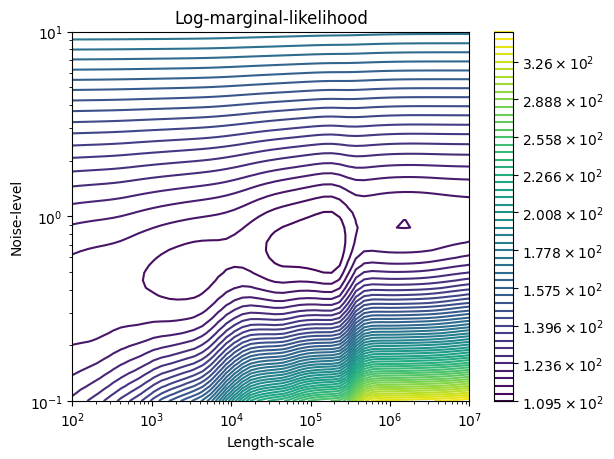

In [ ]:
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py
length_scale = np.logspace(2, 7, num=50)
noise_level = np.logspace(-1, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

# TODO: 3 minima

In [ ]:
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e2, 1e4)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gp(kernel, X, y).kernel_

0.976**2 * RBF(length_scale=228) + WhiteKernel(noise_level=0.387)

In [ ]:
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gp(kernel, X, y).kernel_

0.976**2 * RBF(length_scale=1.68e+05) + WhiteKernel(noise_level=0.706)

We can observe that there are two local minima for the log marginal likelihood with about the same data noise paremeter value. The strongly differ in the RBF kernel lengthscale though. Further analysing we can find out that the global minimun lies at a 2910m lengthscale (the left minimum) and the other local minimum lies at 135km lengthscale. One can say that is the lengthscale is about the distance until which points influence each other (see the graphic below). With our hitchhiking knowledge in mind we can safely say that hitchhiking culture rather changes within a magnitude of 100km than 1km and thus decide for the parameter values that result in the non-global minimum. As a consequence we are setting the bounds in which the lengthscale should lie to 10km to 1000km from now on and assume that if we find an optimal lengthscale that lies within those reasonable bounds it is the local optimum that we want to achieve.

In [ ]:
def rbf(x, l, s=1.0):
    return s * np.exp(-0.5 * (x**2 / l**2))

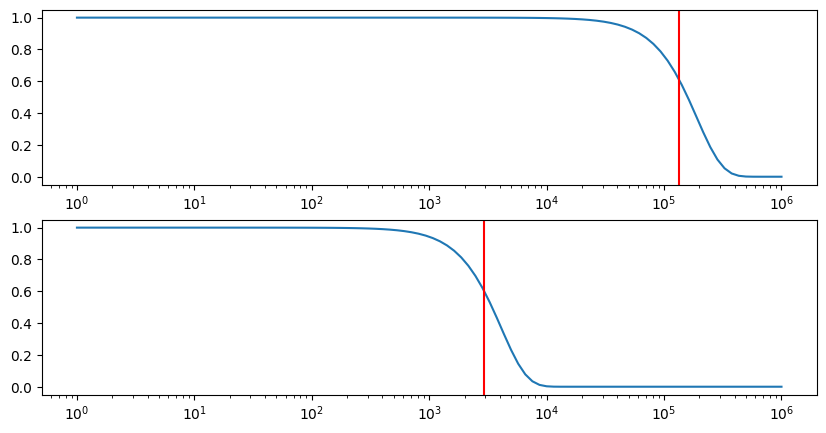

In [ ]:
X = np.logspace(0, 6, 100)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 5))

lengthscale = 1.35e5
ax1.plot(X, rbf(X, lengthscale, 1.0))
ax1.set_xscale("log")
ax1.axvline(x=lengthscale, color='red')

lengthscale = 2.91e3
ax2.plot(X, rbf(X, lengthscale, 1.0))
ax2.set_xscale("log")
ax2.axvline(x=lengthscale, color='red')
plt.show()

To close this first section we are having a first look at the uncertainties that we can retieve from the GP model. As expected uncertainties (manifesting in the 95% confidence intervals) are higher where we have a large variation in the target values or no data at all.

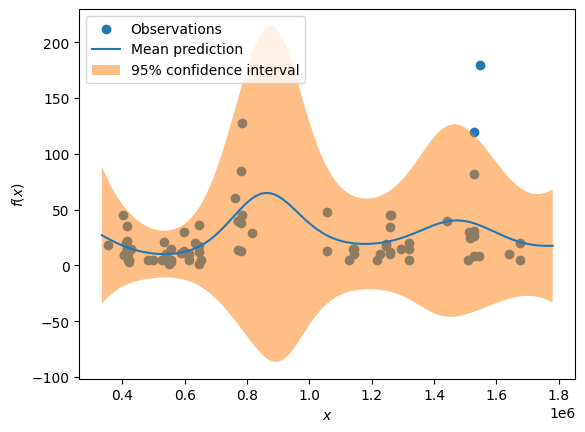

In [12]:
plot_1d_with_uncertainties(target_transform_gpr, X, y, start=tiles_model.lon_intervals[0], stop=tiles_model.lon_intervals[-1])

# Making predictions in longitude-latitude space

Now we have layed the foundation to move on to the actual problem where points are represeted by longitude (x-axis) and latitude (y-axis). With this we are faced with a 2D-version of the above problem and we can build up on the insights we have gained so far.

We will develop predictive models for Germany, Europe and eventually the whole world. The rational behind this is that more challenges will emerge the broader the map gets and the more difference we get in the density of data points. That is why we want to first look at the regions where the majority of the data concentrates. Besides that we want to make sure that the resulting predictive model is particularly precise and informative where most of the hitchhiking traffic occurs which is Europe as is becomes apparent from the below map.

Gradually we will build more and more complex models with more free hyperparameters and more complex kernel functions.

In [ ]:
plot_distribution_of_data_points()

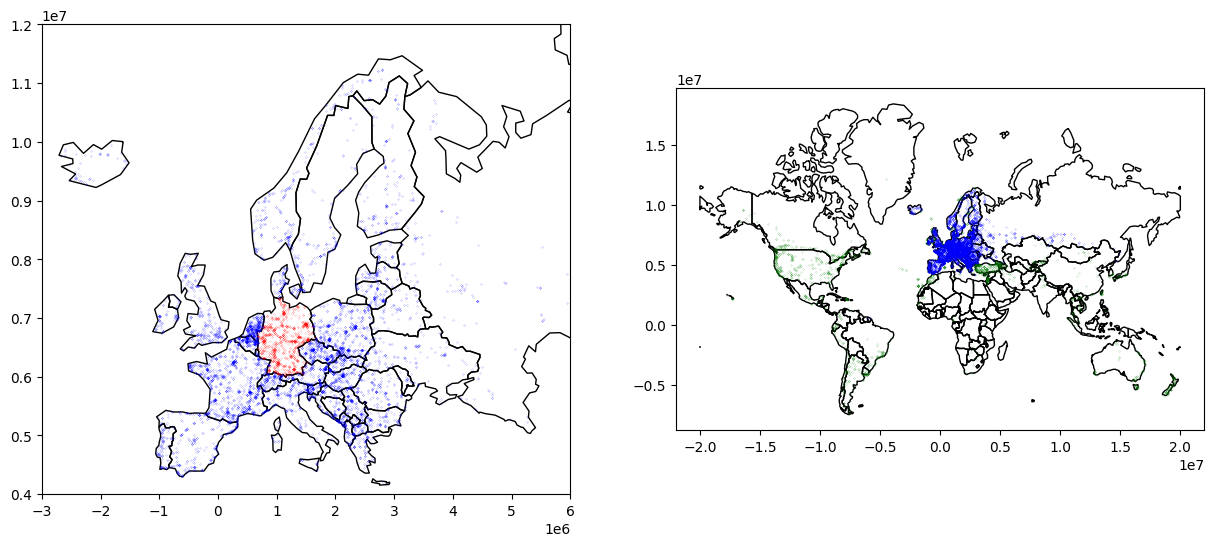

Germany: 10.74 %
Europe without Germany: 69.5 %
Rest of the world: 19.77 %


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

europe.plot(ax=ax1, facecolor="none", edgecolor="black")
germany_data.plot(ax=ax1, markersize=0.01, color="red")
europe_without_germany_data.plot(ax=ax1, markersize=0.01, color="blue")
ax1.set_xlim([-0.3e7, 0.6e7])
ax1.set_ylim([0.4e7, 1.2e7])

countries.plot(ax=ax2, facecolor="none", edgecolor="black")
world_data.plot(ax=ax2, markersize=0.01, color="green")
europe_data.plot(ax=ax2, markersize=0.01, color="blue")

plt.show()

print(f"Germany: {round(len(germany_data) / len(points) * 100, 2)} %")
print(f"Europe without Germany: {round(len(europe_without_germany_data) / len(points) * 100, 2)} %")
print(f"Rest of the world: {round(len(world_data) / len(points) * 100, 2)} %")

## Country level - Germany

First we are taking a look at Germany. We consider the same four models as in the 1D example and compare their performace. From now on we will use 5-fold cross-validation if the training time of the model permits.

In [ ]:
region = 'germany'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
 Training RMSE: 39.47403124630482
 Training MAE: 22.822391431585412
 Validation RMSE: 40.637551940683906
 Validation MAE: 23.710596308405364



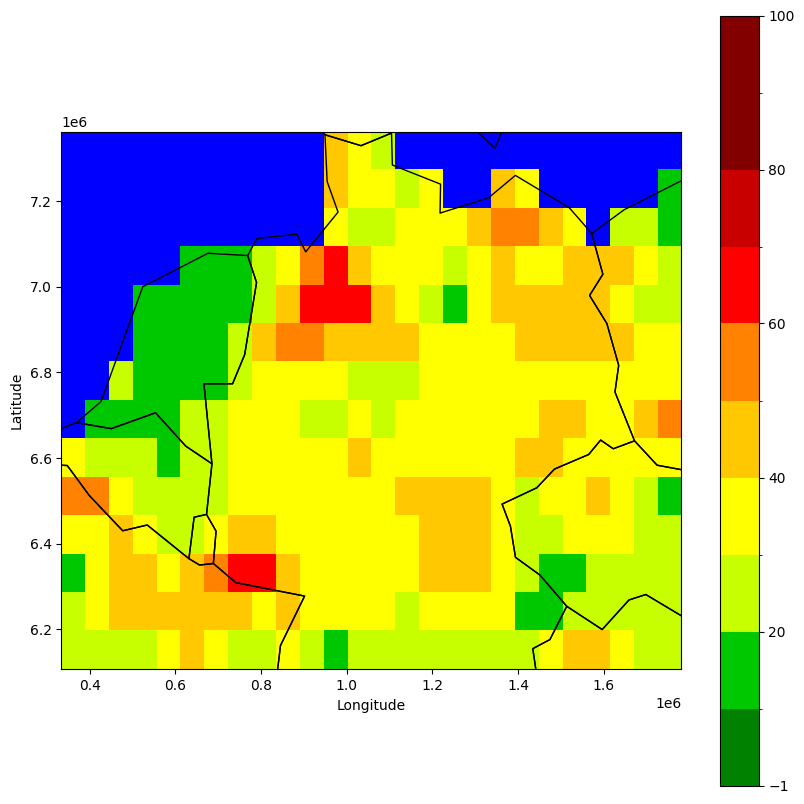

<Figure size 640x480 with 0 Axes>

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
 Training RMSE: 41.700716722506705
 Training MAE: 24.692506681672775
 Validation RMSE: 41.47687241204024
 Validation MAE: 24.692529457136537



100%|██████████| 130/130 [00:00<00:00, 94433.59it/s]

Loading country shapes...


Transforming heatmap...
max map waiting time: 31.49387708992318
min map waiting time: 31.49387708992318
Plotting heatmap...
max waiting time: 675


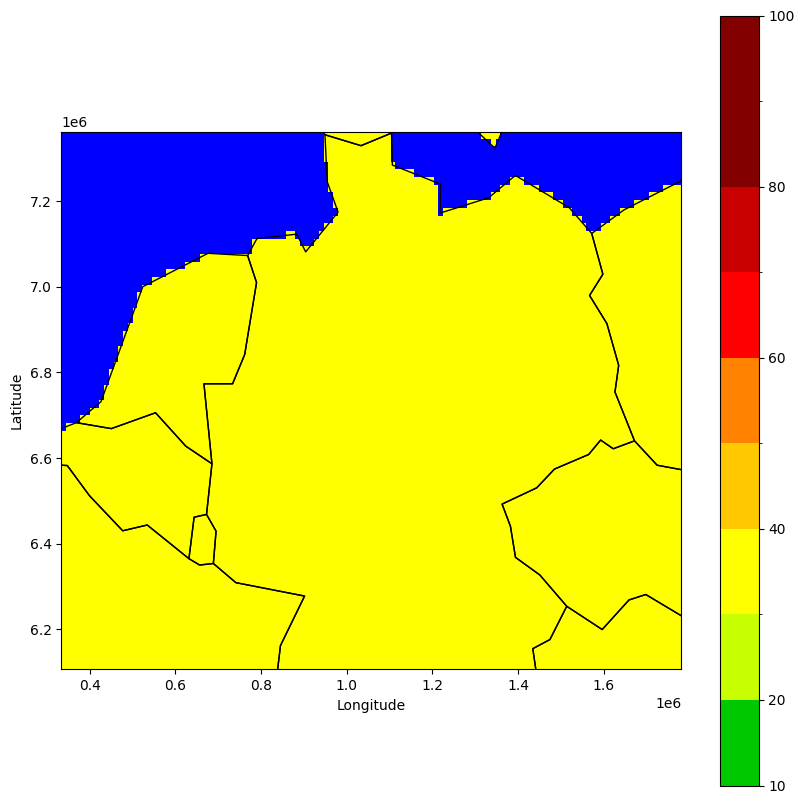

In [ ]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 40.993822365353665
 Training MAE: 24.053454534454843
 Validation RMSE: 41.15913591352587
 Validation MAE: 24.329956706206097



  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [00:00<00:00, 5950.41it/s]

Loading country shapes...


Transforming heatmap...
max map waiting time: 94.16666666666667
min map waiting time: 0.0
Plotting heatmap...
max waiting time: 675


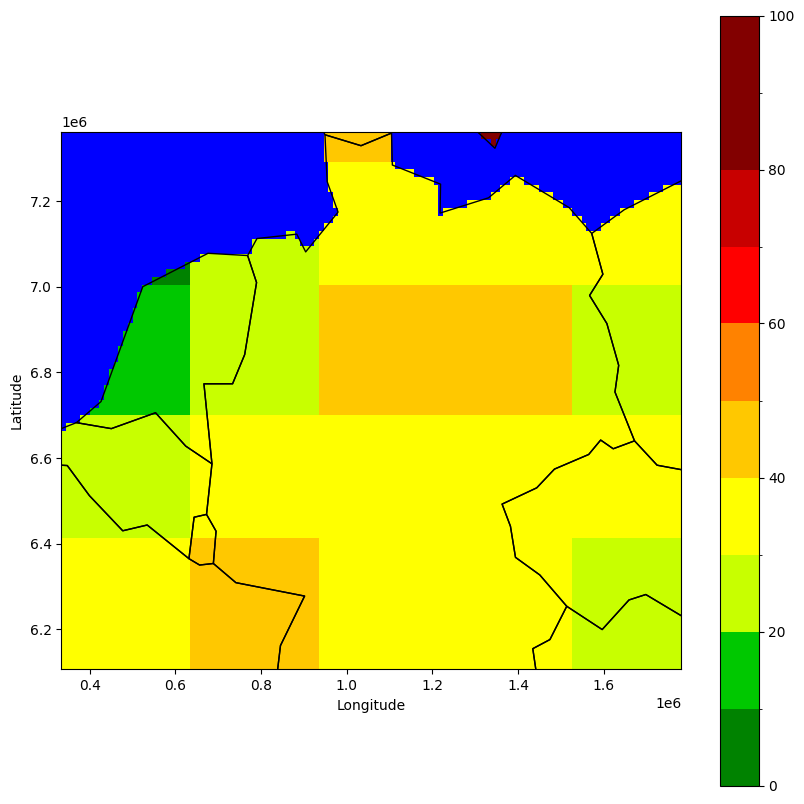

In [ ]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 42.231751539208396
 Training MAE: 20.865172806415778
 Validation RMSE: 42.35572614263516
 Validation MAE: 21.173077697386965

0.97**2 * RBF(length_scale=1.75e+05) + WhiteKernel(noise_level=0.838)


100%|██████████| 130/130 [00:02<00:00, 45.24it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 44.61069616712653
min map waiting time: 8.895708286350908
Plotting heatmap...
max waiting time: 675


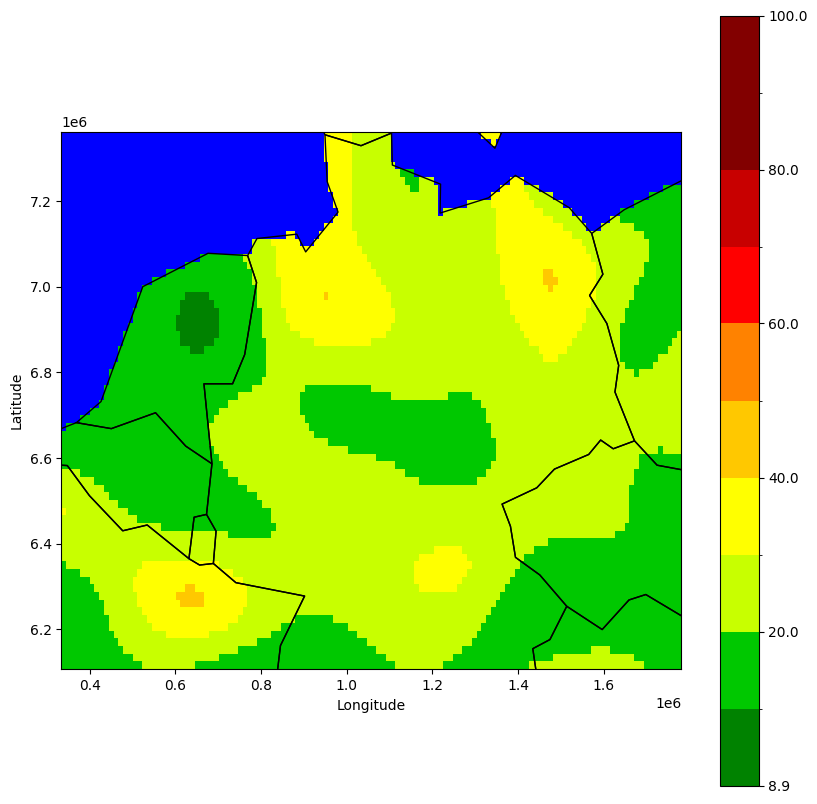

In [ ]:
X = points[['lon', 'lat']].values
y = points['wait'].values


log_transformer = get_log_transformer()
y_transformed = log_transformer.fit_transform(y)

sigma = np.std(y_transformed)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_gpr(kernel)
gpr = evaluate_cv(estimator=gpr, X=X, y=y)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

## Continet level - Europe

In [ ]:
region = 'europe'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
 Training RMSE: 55.88366041022099
 Training MAE: 27.76348575608052
 Validation RMSE: 62.06590691012332
 Validation MAE: 30.424446927459957

Loading country shapes...
Transforming heatmap...
max map waiting time: 1438.4219768579026
min map waiting time: -1.0
Plotting heatmap...
max waiting time: 675


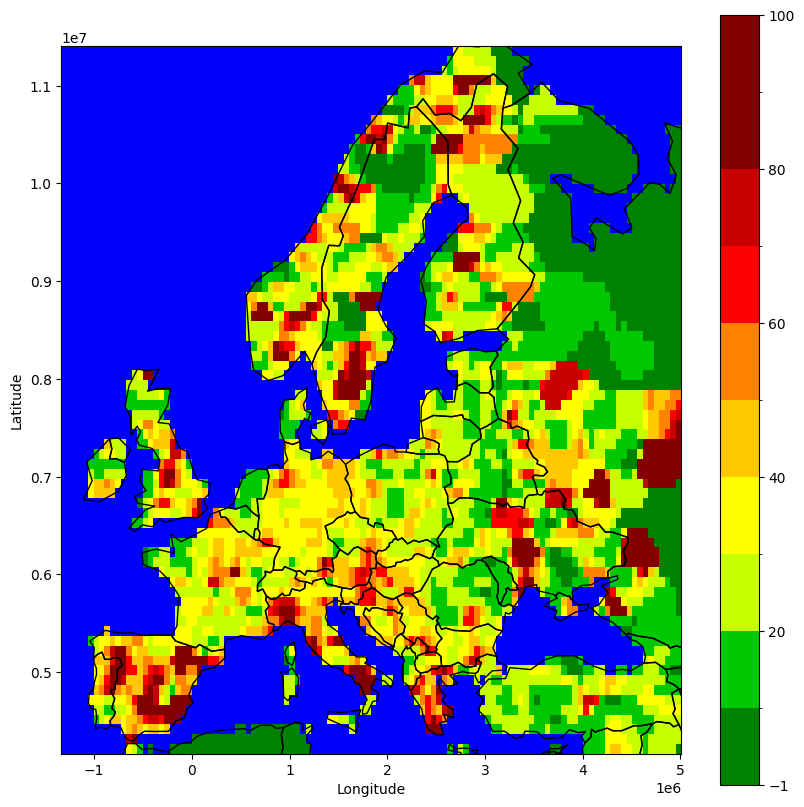

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
 Training RMSE: 61.1214896736692
 Training MAE: 30.93048338563434
 Validation RMSE: 60.709503363271985
 Validation MAE: 30.93180481317244



100%|██████████| 570/570 [00:00<00:00, 10246.98it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 36.507427142121465
min map waiting time: 36.507427142121465
Plotting heatmap...
max waiting time: 675


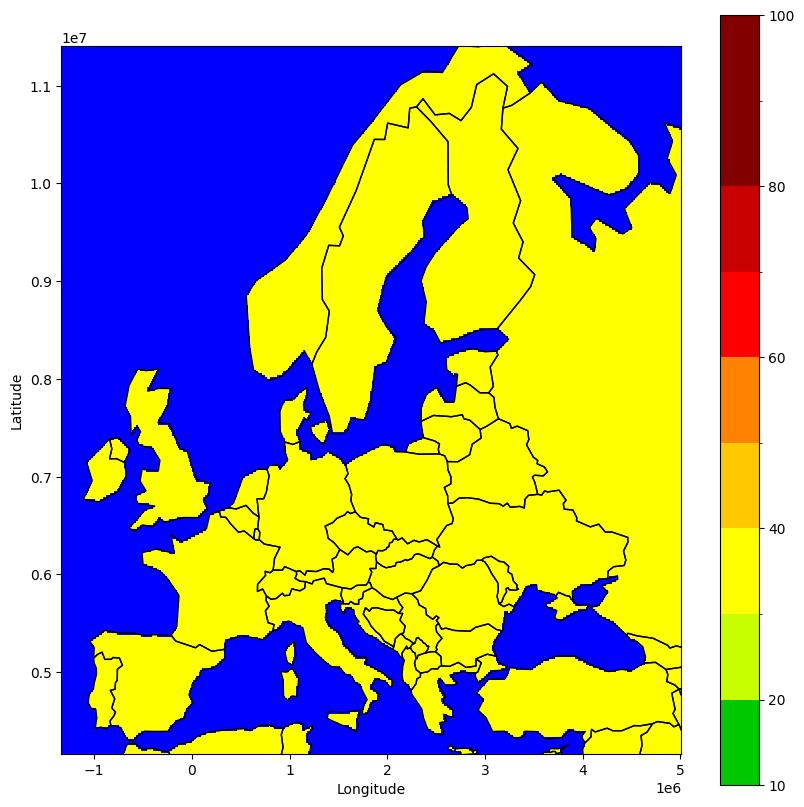

In [ ]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 58.12267730742436
 Training MAE: 29.24067361266657
 Validation RMSE: 62.33582164320135
 Validation MAE: 30.551651590753995



  0%|          | 0/570 [00:00<?, ?it/s]

100%|██████████| 570/570 [00:00<00:00, 613.36it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 725.0
min map waiting time: 0.0
Plotting heatmap...
max waiting time: 675


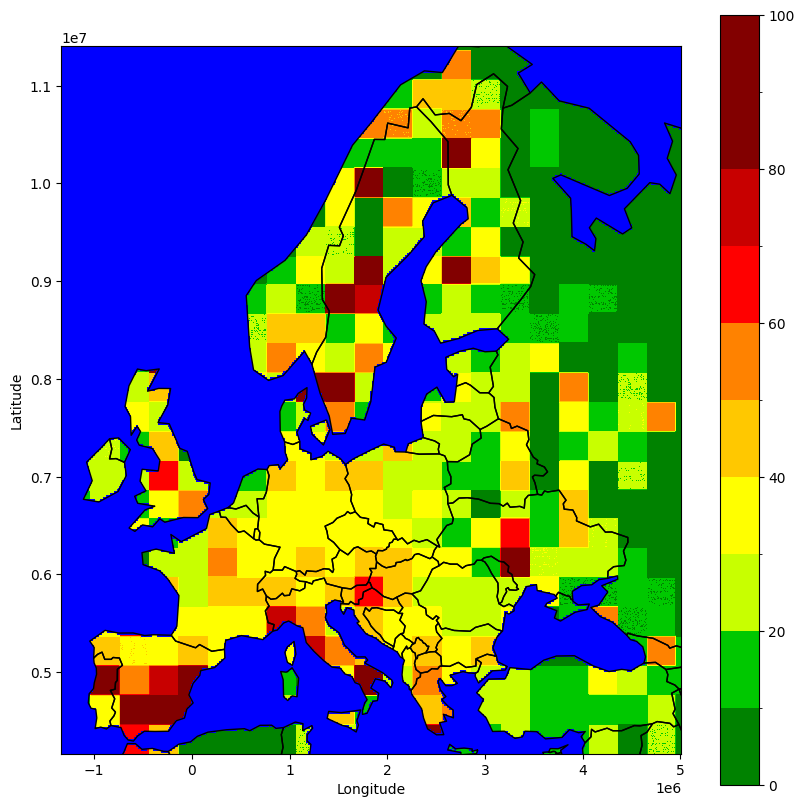

In [ ]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 62.13563120280994
 Training MAE: 25.655885182195174
 Validation RMSE: 61.98574055708957
 Validation MAE: 25.87210487567746

1.01**2 * RBF(length_scale=6.28e+05) + WhiteKernel(noise_level=0.972)


100%|██████████| 570/570 [05:38<00:00,  1.69it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 56.22720078490288
min map waiting time: 2.84546725716762
Plotting heatmap...
max waiting time: 675


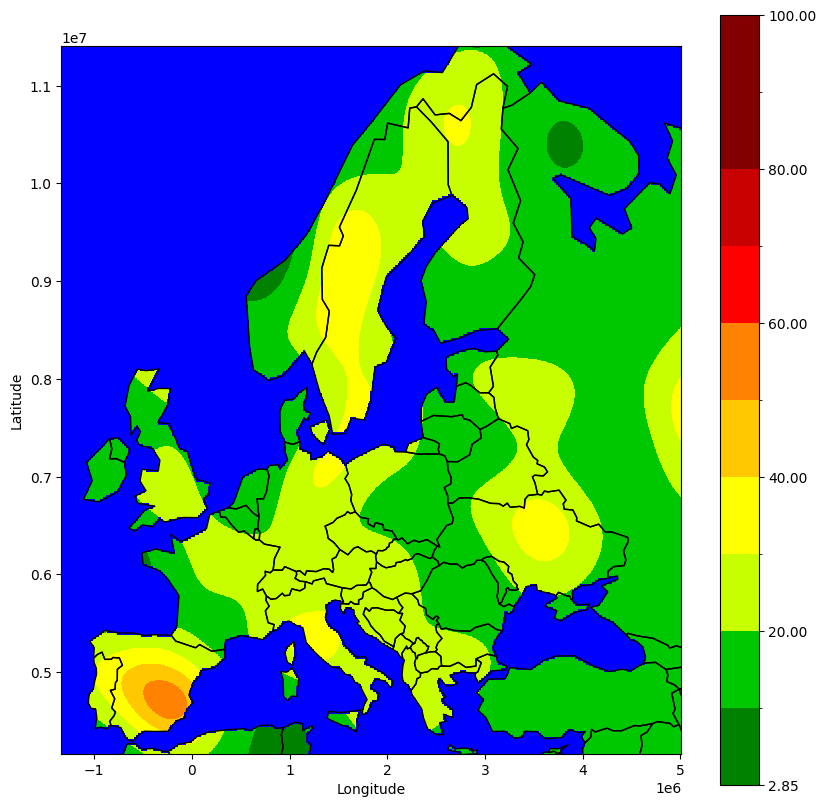

In [ ]:
X = points[['lon', 'lat']].values
y = points['wait'].values


log_transformer = get_log_transformer()
y_transformed = log_transformer.fit_transform(y)

sigma = np.std(y_transformed)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_gpr(kernel)
gpr = evaluate_cv(estimator=gpr, X=X, y=y)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

## Global level

In [ ]:
region = 'world'
_, training, validation = get_from_region(region=region)

Training RMSE: 54.480991431313726
 Training MAE 26.258147142602102
Validation RMSE: 73.58963410921294
 Validation MAE 32.16115192471174


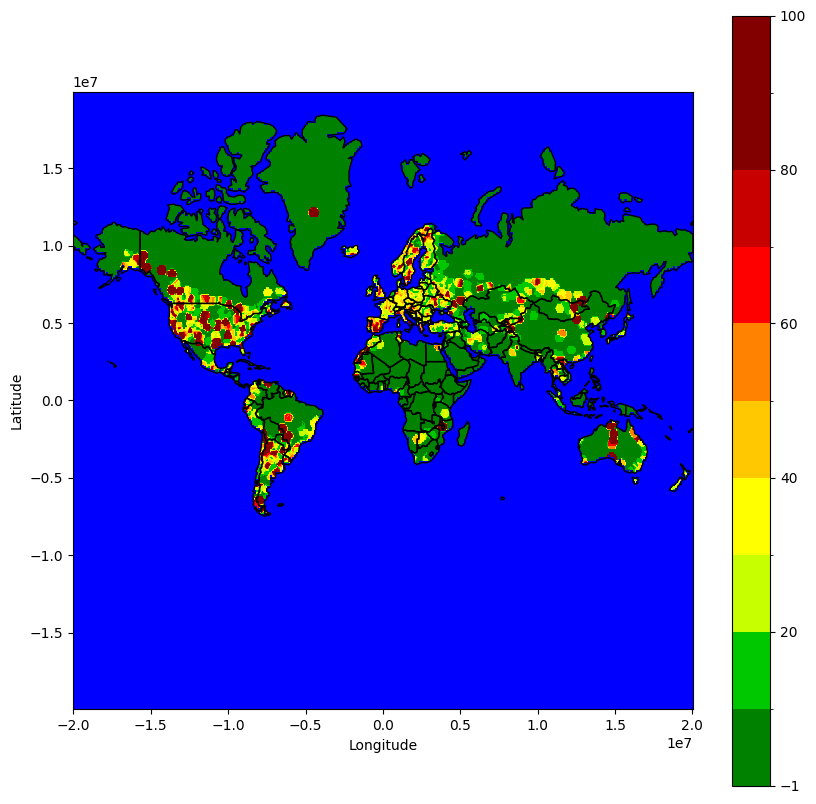

<Figure size 640x480 with 0 Axes>

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(wag_model, train=training, validation=validation)
wag_model.build_map()

Training RMSE: 67.33243790840129
 Training MAE 32.460445936290434
Validation RMSE: 70.72050459010607
 Validation MAE 32.99104134844254


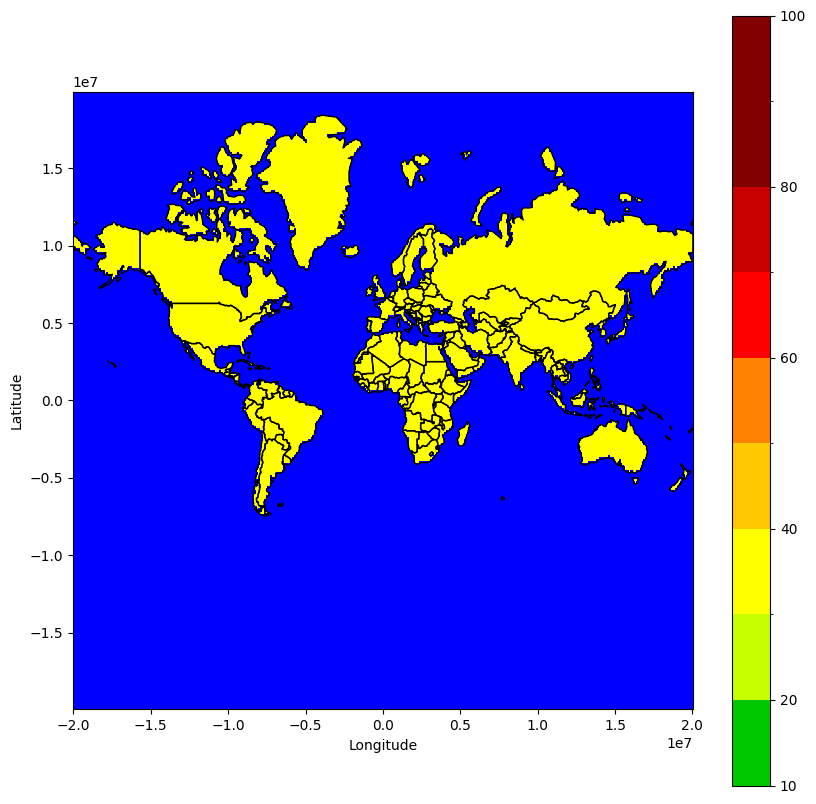

<Figure size 640x480 with 0 Axes>

In [ ]:
average_model = Average()
average_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(average_model, train=training, validation=validation)
map_from_model(average_model, region=region)

Training RMSE: 58.52527670175911
 Training MAE 28.442462108595265
Validation RMSE: 71.63352143635997
 Validation MAE 31.900997595573635


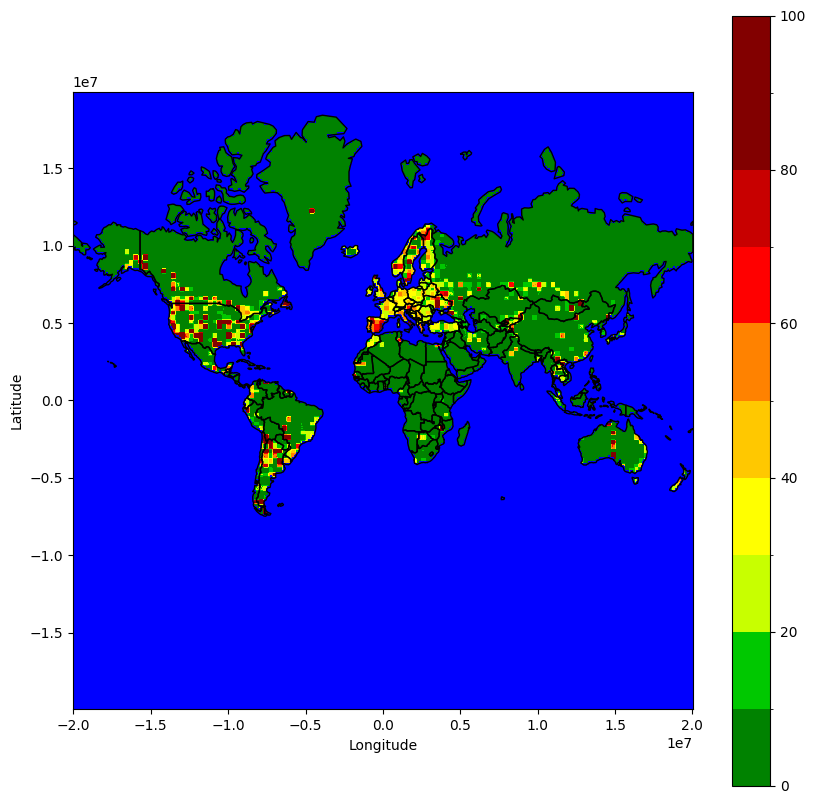

<Figure size 640x480 with 0 Axes>

In [ ]:
tiles_model = Tiles(region=region)
tiles_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(tiles_model, train=training, validation=validation)
map_from_model(tiles_model, region=region)

1.02**2 * RBF(length_scale=6.49e+05) + WhiteKernel(noise_level=0.97)
Training RMSE: 67.11558428284118
 Training MAE 26.544775502048513
Validation RMSE: 69.97549001036668
 Validation MAE 26.994789307219353


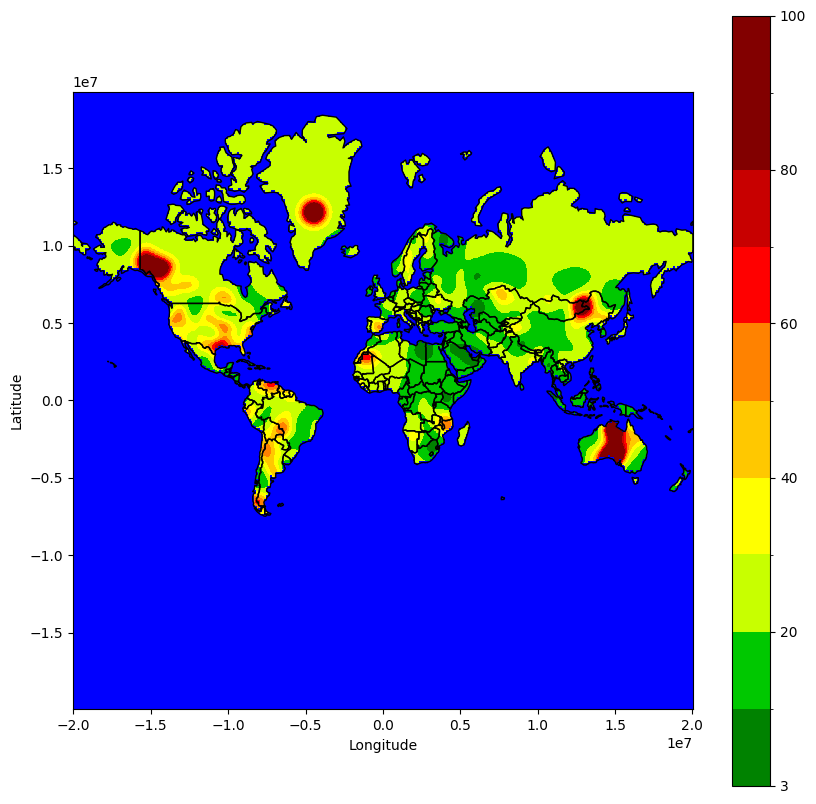

<Figure size 640x480 with 0 Axes>

In [ ]:
X = points[['lon', 'lat']].values
y = points['wait'].values


log_transformer = get_log_transformer()
y_transformed = log_transformer.fit_transform(y)

sigma = np.std(y_transformed)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_optimized_gpr(kernel, X, y)
print(gpr.regressor_.kernel_)
evaluate(gpr, train=training, validation=validation)
map_from_model(gpr, region=region)

# Tweaking the Gaussian process

On all three maps the learning GP model shows better performance than the other three naive models regarding MAE. Thus it seems to be worth it to further develop and improve the GP. In addition the maps built by the GP strongly fullfil our visual requirements.

So far we modelled the GP so that the RBF lengthscale is the same in longitude and latitude direction. We believe that this is a reasonable choice as there is no obvious reason why a single data point should influenc on direction more than the other. Still there might be broad structures in the way land mass is shaped or highways are built that could favor one of the directions. Below we can observe that accoding to the models data points have a stronger influence in the north-south-direction than in the east-west-direction

0.985**2 * RBF(length_scale=[1.89e+05, 3.64e+05]) + WhiteKernel(noise_level=0.878)
Training RMSE: 44.372360563601454
 Training MAE 21.6545669369791
Validation RMSE: 35.50860003989305
 Validation MAE 19.225741562787313


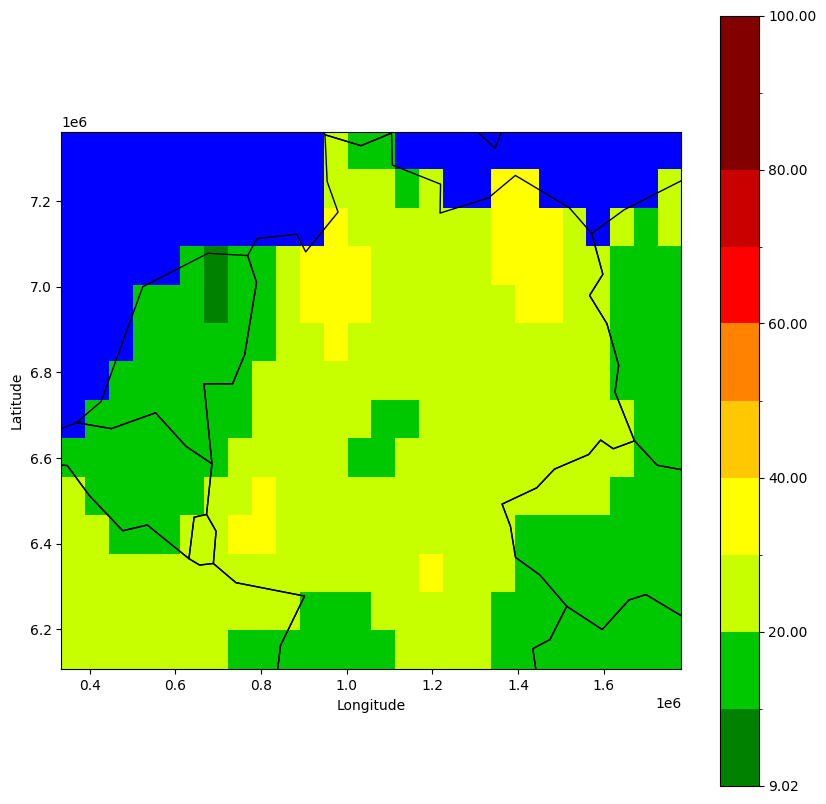

1.01**2 * RBF(length_scale=[2.7e+05, 6.01e+05]) + WhiteKernel(noise_level=0.957)
Training RMSE: 62.10892020799323
 Training MAE 25.380307872997918
Validation RMSE: 62.05605699002502
 Validation MAE 26.236198857650795


<Figure size 640x480 with 0 Axes>

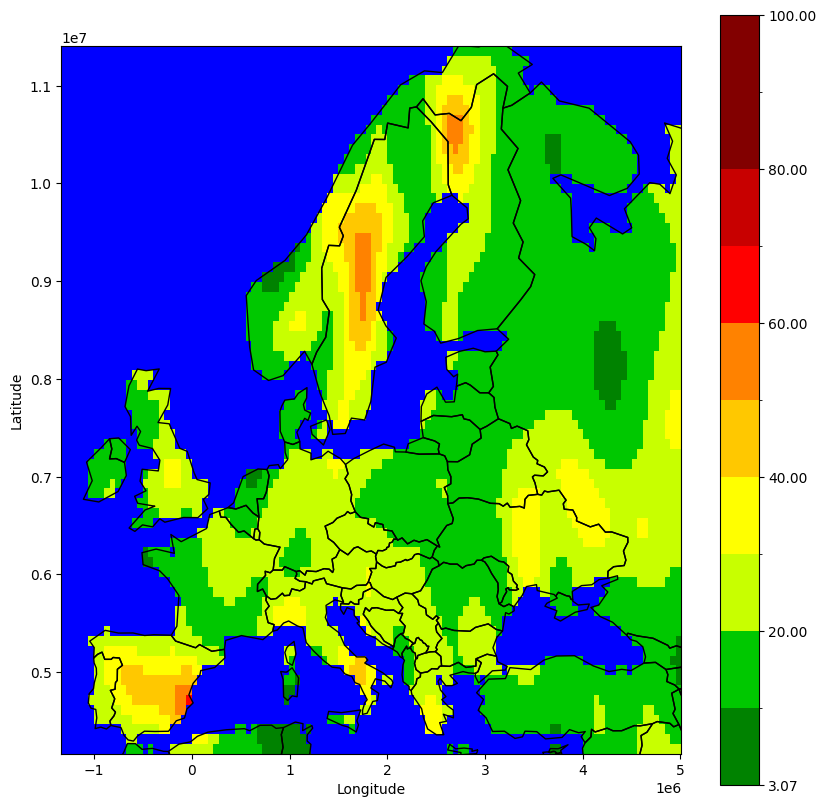

1.02**2 * RBF(length_scale=[6.05e+05, 7.63e+05]) + WhiteKernel(noise_level=0.973)
Training RMSE: 67.35127858746594
 Training MAE 26.527078494201234
Validation RMSE: 71.37262368070293
 Validation MAE 27.495480045374173


<Figure size 640x480 with 0 Axes>

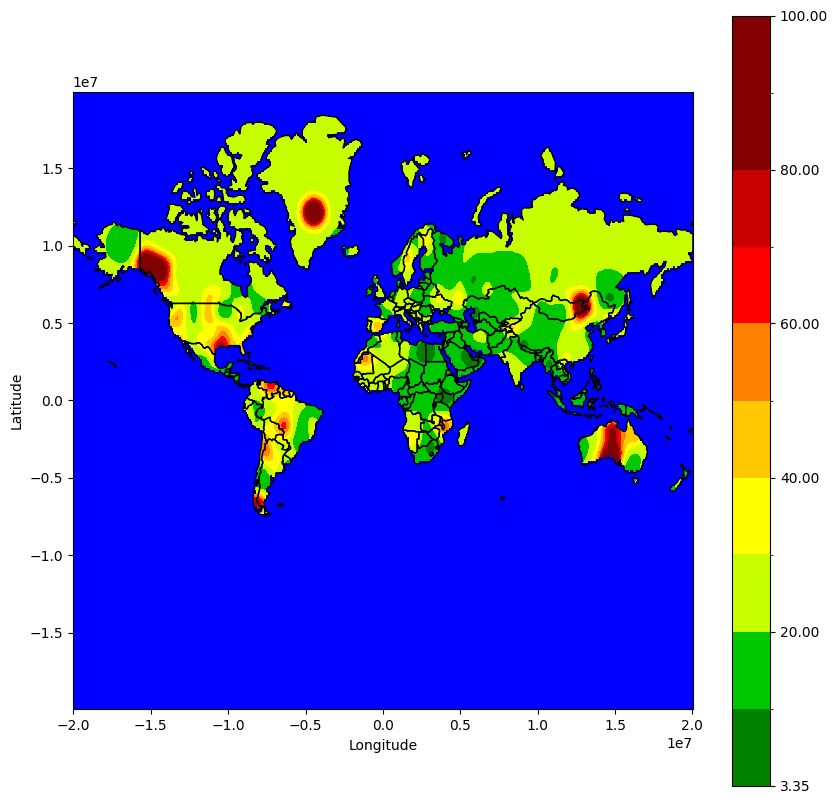

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = ['germany', 'europe', 'world']
for region in regions:
    _, training, validation = get_from_region(region=region)

    X = training[["lon", "lat"]].values
    y = training["wait"].values

    log_transformer = get_log_transformer()
    y_transformed = log_transformer.fit_transform(y)

    sigma = np.std(y_transformed)

    kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * RBF(
        length_scale=[1e5, 1e5],
        length_scale_bounds=[(1e4, 1e6), (1e4, 1e6)],
    ) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


    gpr = get_optimized_gpr(kernel, X, y)
    print(gpr.regressor_.kernel_)
    evaluate(gpr, train=training, validation=validation)
    map_from_model(gpr, region=region)

Through the maps on differently-sized regions we could observe that RBF lengthscales became larger with broader maps. Thus we can assume that there are different levels on which a similar attitude towards hitchhiking exists for example on a regional, state on country level. This is also what we can report from experience. As we can see the regional differences we observe in the map of Germany are no longer visible on the other maps although we clearly have enough data to allow this level of granularity. To mitigate this effect and to incorporate those findings into our model we have to allow it to choose and mix different lengthscales. One way to achieve this is to use multiple RBFs in the kernel by summing them up. Let us use three RBFs as an rather arbitrary choice for now.

We are now freeing the variance parameter (factor in front of the squared exponential kernel) as well to allow to weight the RBFs with different lengthscale differently. If it was fixed the optized model would likely have the same lengthscale for each RBF. Another measure we are applying to prevent same lengthscales is to define non-overlapping lengthscale-bounds for the three RBFs thus hopefully getting a small, medium and large lengthscale. We are choosing narrower variance bounds for the RBF with the smallest lengthscale as allowing short lengthscales and high variance often results in overfitting to the data which we want to prevent.

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 500000.0. Decreasing the bound

0.314**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.162**2 * RBF(length_scale=[1.83e+05, 2.93e+05]) + 0.164**2 * RBF(length_scale=[5e+05, 5.76e+05]) + WhiteKernel(noise_level=0.883)
Training RMSE: 61.09641429927832
 Training MAE 24.28312381747242
Validation RMSE: 61.774041315015644
 Validation MAE 25.952724263421928


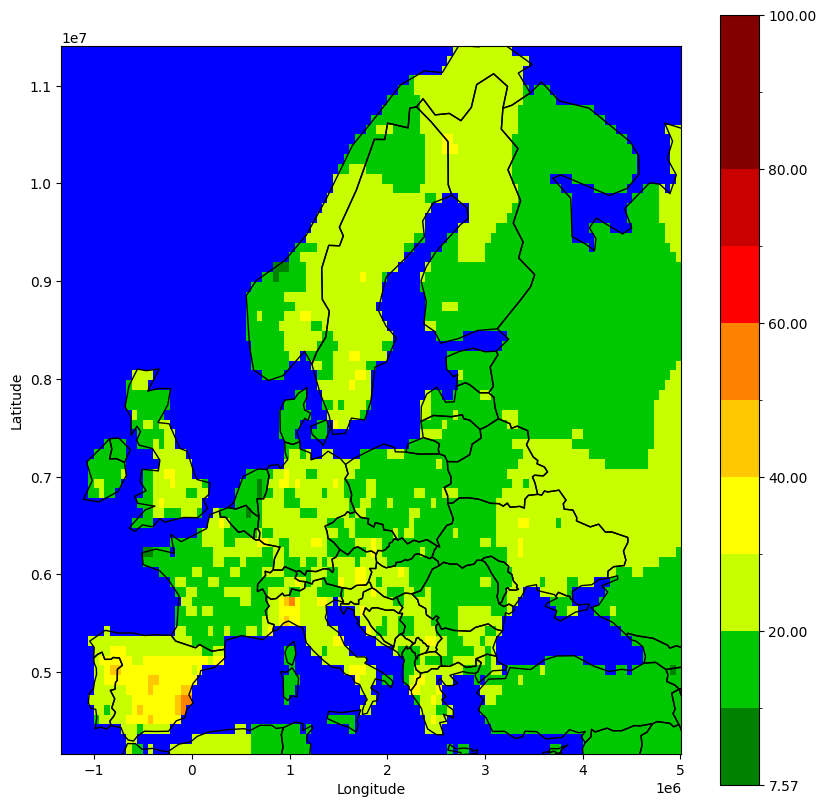

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 1000000.0. Increasing the boun

0.319**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.192**2 * RBF(length_scale=[2.01e+05, 3.04e+05]) + 0.311**2 * RBF(length_scale=[1e+06, 1e+06]) + WhiteKernel(noise_level=0.886)
Training RMSE: 66.7072704117254
 Training MAE 25.26602638016309
Validation RMSE: 71.6226544519805
 Validation MAE 27.12933776716772


<Figure size 640x480 with 0 Axes>

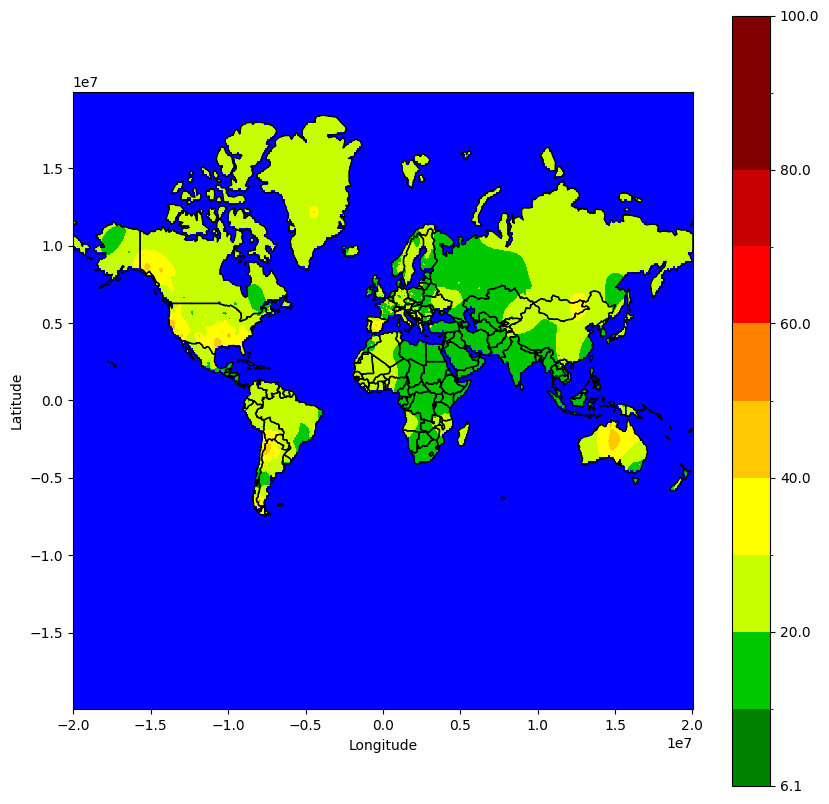

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = ['europe', 'world']
for region in regions:
    _, training, validation = get_from_region(region=region)

    X = training[["lon", "lat"]].values
    y = training["wait"].values

    log_transformer = get_log_transformer()
    y_transformed = log_transformer.fit_transform(y)

    sigma = np.std(y_transformed)

    rbf = RBF(
        length_scale=[5e4, 5e4], length_scale_bounds=(5e4, 1e5)
    )
    rbf2 = RBF(
        length_scale=[1e5, 1e5], length_scale_bounds=(1e5, 5e5)
    )
    rbf3 = RBF(
        length_scale=[5e5, 5e5], length_scale_bounds=(5e5, 1e6)
    )

    kernel = (
        ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
        + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
    )


    gpr = get_optimized_gpr(kernel, X, y)
    print(gpr.regressor_.kernel_)
    evaluate(gpr, train=training, validation=validation)
    map_from_model(gpr, region=region)

# Exploiting the probabilistic approach

Eventually we can turn towards one of the reasons we applyed a probabilistic model such as the GP. Alongside the mean of the predictive distribution (the function we are using to make predictions) it gives us uncertainties about the predictions via the standard deviations of the predictive distribution. Those are especially handy when we communicate the results of this work via a map to also convey that predictions made in certain area of the world are uncertain because of a lack of training data in that region and thus should not be trusted.

In [ ]:
stop

NameError: name 'stop' is not defined

# Further Ideas and Work


There are a few ideas how all this could be developed further.

1. As stated in the beginning there is measurement and outlier noise in the data. So far we did not model measurement noise specifically. An idea would be to assume that measurement noise increases with waiting time. One might be able to learn a function that represents this kind of noise. Giving an example one might assume that for a recorded waiting time of 5min it only deviates from the real waiting time whereas for 4h there is a 30min deviation.

2. Combining multiple RBF functions in one kernel is a quite simple way to model a variety of lengthscales. Being more sophisticated one could apply multiple rational quadratic kernels instead as this kernel models a distribution over lengthscales.

3. Applying the log-transformation to the data before applying the GP allowed us to never get negative predictions. On the other end one might not want to get predictions larger than the longest recorded waiting time and thus constrain the upper bound as well. For example this could be achieved by applying a probit-transformation. However we did not see that too large predictions were a problem so far.

4. As training a GP on a large dataset such as for the whole world takes some time we could not search further over the parameters of our final model although one ideally would not want to end up with parameter values at the interval bounds as it shows that the model is not optimal. For optimization and finding local optima one could have a look at Bayesian optimization.

5. On could go beyond longitude and latitude as features for each data points e.g. also taking the date or day of the week into account. We are afraid we do not have enough data at the moment to build meaningful models that way.

# Bibliography

resources:
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
- https://domino.ai/blog/fitting-gaussian-process-models-python
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
- https://www.cs.toronto.edu/~duvenaud/cookbook/

log space:
- https://github.com/dfm/george/issues/106
- https://www.osti.gov/servlets/purl/1847480

reading:
- https://distill.pub/2020/bayesian-optimization/
